In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
import copy
import seaborn as sns
import tensorflow as tf
from sklearn.linear_model import LinearRegression

# Dataset

In [ ]:
# Read the "Daily Forex Rate" csv file from a google drive directory

from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/Colab/Gsheet Connect Ex/daily_forex_rates.csv'

df = pd.read_csv(file_path)
df

Mounted at /content/drive


,currency,base_currency,currency_name,exchange_rate,date
0,ZWL,EUR,Zimbabwean Dollar,333.100155,2025-01-21
1,GHS,EUR,Ghanaian Cedi,15.476757,2025-01-21
2,HRK,EUR,Croatian Kuna,7.633949,2025-01-21
3,HNL,EUR,Honduran Lempira,26.201750,2025-01-21
4,HKD,EUR,Hong Kong Dollar,8.054134,2025-01-21
...,...,...,...,...,...
398371,JPY,EUR,Japanese Yen,133.350000,2004-09-01
398372,CAD,EUR,Canadian Dollar,1.596700,2004-08-31
398373,JPY,EUR,Japanese Yen,132.850000,2004-08-31
398374,AUD,EUR,Australian Dollar,1.729600,2004-08-31


In [ ]:
# Filter for currency 'IDR'
df_idr = df[df['currency'] == 'IDR']

# Sort by date
df_idr_sorted = df_idr.sort_values(by='date')

df_idr_sorted

,currency,base_currency,currency_name,exchange_rate,date
375440,IDR,EUR,Indonesian Rupiah,15107.000000,2014-11-24
375300,IDR,EUR,Indonesian Rupiah,15218.000000,2014-11-25
375189,IDR,EUR,Indonesian Rupiah,15270.000000,2014-11-26
375078,IDR,EUR,Indonesian Rupiah,15155.000000,2014-11-27
374842,IDR,EUR,Indonesian Rupiah,15241.000000,2014-11-28
...,...,...,...,...,...
691,IDR,EUR,Indonesian Rupiah,16900.133320,2025-01-17
601,IDR,EUR,Indonesian Rupiah,16896.841442,2025-01-18
365,IDR,EUR,Indonesian Rupiah,16896.841442,2025-01-19
235,IDR,EUR,Indonesian Rupiah,16867.854127,2025-01-20


In [ ]:
# Export to Google Drive as a CSV file (Only for IDR rates)
df_idr_sorted.to_csv('/content/drive/MyDrive/Colab/Gsheet Connect Ex/daily_forex_rates_idr.csv', index=False)

<ipython-input-7-c7edaf876053>:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_idr = df_idr_sorted.resample('M').last()


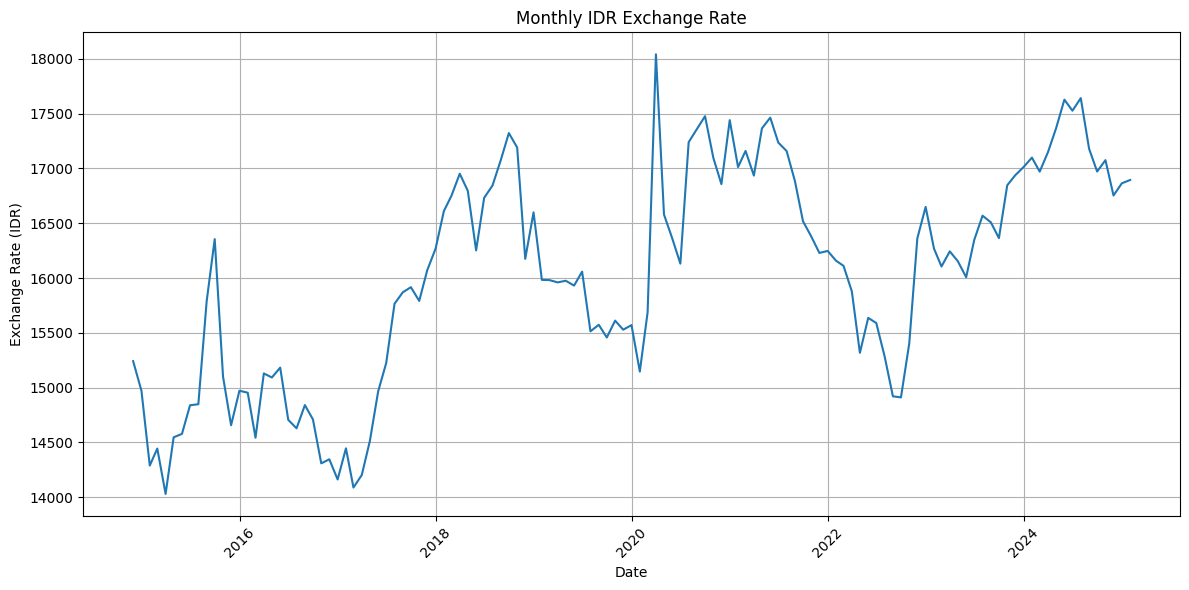

In [ ]:
# For plotting, limit it to only show monthly change (for every date 1 every month). After that plot the exchange rate

# Convert 'date' column to datetime objects
df_idr_sorted.index = pd.to_datetime(df_idr_sorted['date'])

# Resample to monthly frequency, taking the last value of each month
monthly_idr = df_idr_sorted.resample('M').last()

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(monthly_idr.index, monthly_idr['exchange_rate'])
plt.xlabel('Date')
plt.ylabel('Exchange Rate (IDR)')
plt.title('Monthly IDR Exchange Rate')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Train, Valid and Test

In [ ]:
# Train Valid Test Dataset here
d = df_idr_sorted
train, valid, test = np.split(d.sample(frac=1, random_state=42), [int(0.6*len(d)), int(0.8*len(d))])

def get_xy(dataframe, y_label, x_labels):

    dataframe = copy.deepcopy(dataframe)

    # If no x_labels are provided, use all columns except y_label as features
    if x_labels is None or len(x_labels) == 0:
        X = dataframe[[c for c in dataframe.columns if c != y_label]].values
    else:
        # If only one column is provided in x_labels, reshape it to 2D
        if len(x_labels) == 1:
            X = dataframe[x_labels[0]].values.reshape(-1, 1)
        else:
            X = dataframe[x_labels].values

    # Extract the target/label column and reshape it to 2D
    y = dataframe[y_label].values.reshape(-1, 1)

    # Combine features and labels into a single dataset
    data = np.hstack((X, y))

    return data, X, y

_, X_train, y_train = get_xy(train, "exchange_rate", x_labels=['date'])
_, X_valid, y_valid = get_xy(valid, "exchange_rate", x_labels=['date'])
_, X_test, y_test = get_xy(test, "exchange_rate", x_labels=['date'])

# Convert to datetime, then as numeric (integers)
X_train = X_train.astype('datetime64[ns]').astype(int)
X_valid = X_valid.astype('datetime64[ns]').astype(int)
X_test = X_test.astype('datetime64[ns]').astype(int)

len(X_train), len(X_valid), len(X_test)

/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


(1666, 556, 556)

# Model 1: Using Simple Linear Regression

In [ ]:
# Apply the linear regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

print("Coefficient: ", lr_model.coef_)
print("Intercept: ", lr_model.intercept_)
print("R2 Score: ", lr_model.score(X_train, y_train))

Coefficient:  [[6.99265951e-15]]
Intercept:  [4972.47469488]
R2 Score:  0.44560739323831655


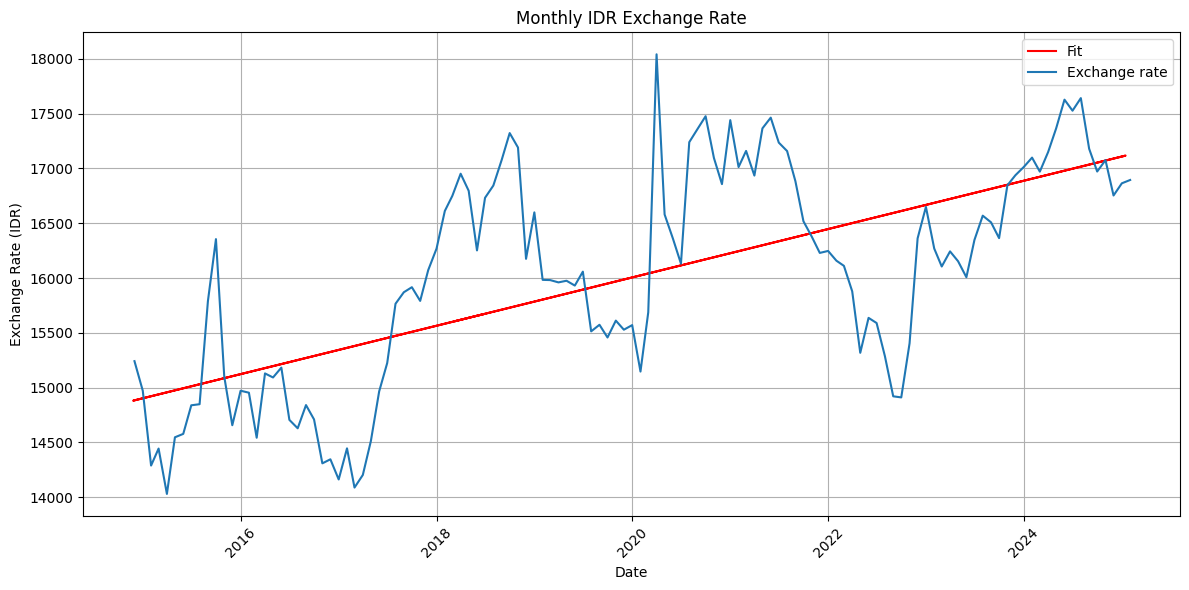

In [ ]:
# Predict the model
y_pred = lr_model.predict(np.array(X_test).reshape(-1, 1))

X_test_asdate = X_test.astype('datetime64[ns]')

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(X_test_asdate, y_pred, label = 'Fit', color = 'red')
plt.plot(monthly_idr.index, monthly_idr['exchange_rate'], label = 'Exchange rate')
plt.xlabel('Date')
plt.ylabel('Exchange Rate (IDR)')
plt.title('Monthly IDR Exchange Rate')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()

## Trying Manual Inputs
From Jan 2025 to Jan 2028

In [ ]:
# Manually input dates to predict
dates_to_predict = np.array([['2025-01-01'],['2026-01-01'],['2027-01-01'],['2028-01-01'],['2029-01-01'],['2030-01-01']])
dates_to_predict_int = dates_to_predict.astype('datetime64[ns]').astype(int)

exrate_pred = lr_model.predict(dates_to_predict_int.reshape(-1, 1))
exrate_pred = np.round(exrate_pred).astype(int)

for i in range(len(dates_to_predict)):
  print(f"{dates_to_predict[i][0]} predicted rate: {exrate_pred[i][0]}")

2025-01-01 predicted rate: 17110
2026-01-01 predicted rate: 17330
2027-01-01 predicted rate: 17551
2028-01-01 predicted rate: 17771
2029-01-01 predicted rate: 17992
2030-01-01 predicted rate: 18213


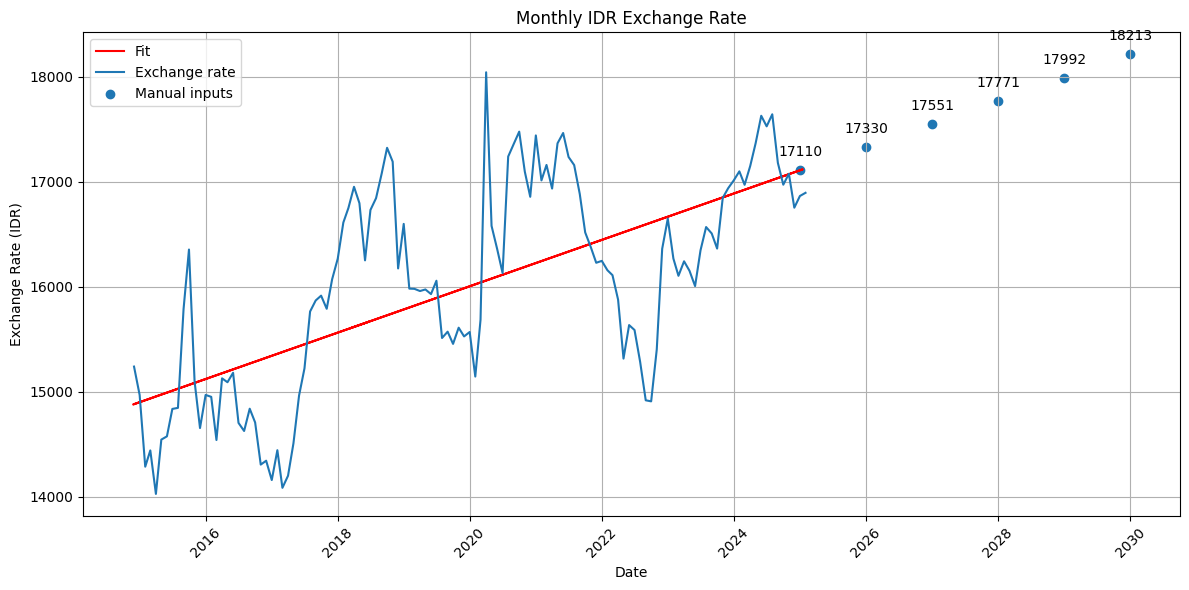

In [ ]:
# Plotting the manual inputs
plt.figure(figsize=(12, 6))
plt.plot(X_test_asdate, y_pred, label = 'Fit', color = 'red')
plt.plot(monthly_idr.index, monthly_idr['exchange_rate'], label = 'Exchange rate')
plt.scatter(dates_to_predict, exrate_pred, label = 'Manual inputs')
plt.xlabel('Date')
plt.ylabel('Exchange Rate (IDR)')
plt.title('Monthly IDR Exchange Rate')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()

# Scatter plot with data labels
for i, txt in enumerate(exrate_pred):
    plt.annotate(txt[0], (dates_to_predict[i], exrate_pred[i]), textcoords="offset points", xytext=(0, 10), ha='center')

plt.show()

# Model 2: Using Support Vector Regression (SVR)

In [ ]:
from sklearn.svm import SVR
from sklearn.utils import resample

n_bootstrap = 10 # Number of bootstrap samples to create
bootstrap_preds = np.zeros((n_bootstrap, len(X_test))) # Matrix to hold bootstrap predictions

for i in range(n_bootstrap):
    X_train_sample, y_train_sample = resample(X_train, y_train.ravel())
    model = SVR(kernel='rbf', C=1e3, gamma=0.1)
    model.fit(X_train_sample, y_train_sample)
    predictions = model.predict(X_test) # Generate bootstrap predictions
    bootstrap_preds[i, :] = predictions
    print(f"Bootstrap pred: ",bootstrap_preds[i, :])

# lower_bound = np.percentile(bootstrap_preds, 2.5, axis=0) # Calculate prediction interval
# upper_bound = np.percentile(bootstrap_preds, 97.5, axis=0)

# plt.figure(figsize=(10, 8))
# plt.plot(np.arange(y_train.shape[0], y_train.shape[0] + y_test.shape[0]), predictions.flatten(), color='blue', label='Predicted')
# plt.fill_between(np.arange(y_train.shape[0], y_train.shape[0] + y_test.shape[0]), lower_bound.flatten(), upper_bound.flatten(), color='blue', alpha=0.2)
# plt.plot(np.arange(0, y_train.shape[0] + y_test.shape[0]), sc_y.inverse_transform(np.vstack((y_train, y_test))).flatten(), color='red', label='Actual')
# plt.xlabel('Day')
# plt.ylabel('Price')
# plt.title('Stock Price Forecasting using Support Vector Regression')
# plt.legend()
# #plt.show()
# plt.savefig('svr_stock.png')